<a href="https://colab.research.google.com/github/Bart1002/Neural-machine-translation/blob/master/Encoder_Decoder_model_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# donload dataset

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True
)

path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
#convert unicode characters to ascii

def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s)
  if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  # creating a space between a word and the punctuation following it
  w = re.sub(r"([?.!,¿])", r" \1 ", w)

  w = re.sub(r'[" "]+'," ",w)


  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+"," ",w)

  w = w.strip()

  w = '<start> ' + w + ' <end>'

  return w

In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format [ENGLISH, SPANISH]

def create_dataset(path, num_examples):
  lines = io.open(path,encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]

  return zip(*word_pairs)

In [ ]:
en,sp = create_dataset(path_to_file,None)

print(en[-1])
print(sp[-1])
print('\n\n')
print(len(en))
print(len(sp))

<start> if you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo. <end>
<start> si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado. <end>



118964
118964


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters=''
  )
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
  
  return tensor, lang_tokenizer

In [ ]:
def load_dataset(path, num_examples=None):

  targ_lang,inp_lang = create_dataset(path,num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer,targ_lang_tokenizer

In [ ]:
input_tensor,target_tensor,inp_lang,targ_lang = load_dataset(path_to_file,130000)
max_length_targ,max_length_inp = target_tensor.shape[1],input_tensor.shape[1]

print(max_length_targ,max_length_inp)

49 51


In [ ]:
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor,test_size=0.2)

In [ ]:
def convert(lang,tensor):
  for i in tensor:
    if i != 0:
      print(f"{i} ---> {lang.index_word[i]}")

convert(inp_lang,input_tensor_train[2])

1 ---> <start>
61 ---> solo
137 ---> tenemos
108 ---> tres
546 ---> horas.
2 ---> <end>


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,enc_units,batch_sz):
    super(Encoder,self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
  def __call__(self,x,hidden):
    x = self.embedding(x)
    output, state = self.gru(x,initial_state=hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz,self.enc_units))

In [ ]:
encoder = Encoder(vocab_inp_size,embedding_dim,units,BATCH_SIZE)

sample_hidden = encoder.initialize_hidden_state()
sample_batch = tf.ones((BATCH_SIZE,max_length_inp))

sample_out, sample_state = encoder(sample_batch,sample_hidden)

print(f"Encoder output shpe : {sample_out.shape} ,hidden state shape : {sample_state.shape}")

Encoder output shpe : (64, 51, 1024) ,hidden state shape : (64, 1024)


In [ ]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(BahdanauAttention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def __call__(self,query,value):
    query_with_time_axis = tf.expand_dims(query,1)

    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(value)))
    
    attention_weights = tf.nn.softmax(score,axis=1)

    context_vector = attention_weights * value
    context_vector = tf.reduce_sum(context_vector,axis=1)

    return context_vector, attention_weights

In [ ]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_out)

print(f"Attention output shape: {attention_result.shape} , attention weights shape: {attention_weights.shape}")

Attention output shape: (64, 1024) , attention weights shape: (64, 51, 1)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self,vocab_size,embedding_dim,dec_units,batch_sz):
    super(Decoder,self).__init__()
    self.vocab_size = vocab_size
    self.batch_sz = batch_sz
    self.embedding = tf.keras.layers.Embedding(vocab_size,embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units,
                                  return_sequences = True,
                                  return_state = True,
                                  recurrent_initializer='glorot_uniform')    
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(dec_units)
  def __call__(self,x,hidden,enc_output):
    context_vector, attention_weights = self.attention(hidden,enc_output)
    
    x = self.embedding(x)

    x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)

    output, state = self.gru(x)

    output = tf.reshape(output,(-1,output.shape[2]))

    x = self.fc(x)

    return x, state, attention_weights

In [ ]:
decoder = Decoder(vocab_tar_size,embedding_dim,units,BATCH_SIZE)

sample_decoder_output,_,_ = decoder(tf.ones((BATCH_SIZE,1)),sample_hidden,sample_out)

print(f"Decoder output shape: {sample_decoder_output.shape}")

Decoder output shape: (64, 1, 22415)


In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                     reduction='none')


def loss_function(real,preds):
  mask = tf.math.logical_not(tf.math.equal(real,0))
  loss_ = loss_object(real,preds)

  mask = tf.cast(mask,loss_.dtype)
  loss_ *=mask

  return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = '/content/gdrive/My Drive/Colab Notebooks/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [ ]:
@tf.function
def train_step(inp,targ,enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp,enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']]*BATCH_SIZE,1)

    for t in range(1,targ.shape[1]):
      predictions, dec_hidden, _ = decoder(dec_input,dec_hidden,enc_output)

      loss += loss_function(targ[:,t],predictions)

      dec_input = tf.expand_dims(targ[:,t],1)

    batch_loss = loss/int(targ.shape[1])

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss,variables)

    optimizer.apply_gradients(zip(gradients,variables))

    return batch_loss

In [ ]:
# EPOCHS = 12

# for e in range(1,EPOCHS+1):
#   start = time.time()

#   enc_hidden = encoder.initialize_hidden_state()
#   total_loss = 0

#   for (batch, (inp,targ)) in enumerate(dataset.take(steps_per_epoch)):
#     batch_loss = train_step(inp,targ,enc_hidden)
#     total_loss += batch_loss

#     if batch% 100 == 0:
#       print(f"Epoch {e} Batch {batch} Loss {batch_loss.numpy()}")

#   if e%2 == 0 and e != 0 :
#     checkpoint.save(file_prefix = checkpoint_prefix)

#   print(f"Epoch {e} Loss {total_loss/steps_per_epoch}")
#   print(f"Time taken: {time.time() - start}")


In [ ]:
# checkpoint.save(file_prefix = checkpoint_prefix)?
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ,max_length_inp))

  sentence = preprocess_sentence(sentence)
  # print(sentence)
  sentence = inp_lang.texts_to_sequences([sentence])
  # print(sentence)
  sentence = tf.keras.preprocessing.sequence.pad_sequences(sentence,max_length_inp,padding='post')
  print(sentence)

  input_tensor = tf.convert_to_tensor(sentence)
  hidden = tf.zeros((1,units))

  enc_output, enc_hidden = encoder(input_tensor,hidden)

  # print(enc_output.shape,enc_hidden.shape)

  dec_input =tf.expand_dims([targ_lang.word_index['<start>']],axis=1)
  dec_hidden = enc_hidden

  target=[inp_lang.word_index['<start>']]
  for i in range(max_length_targ):
    pred,dec_hidden,attention_weights = decoder(dec_input,dec_hidden,enc_output)
    # print(pred.shape,dec_hidden.shape,attention_weights.shape)
    
    
    attention_plot[i] = attention_weights[0,:,0]

    target.append(tf.argmax(pred,axis=2).numpy()[0][0])

    dec_input = tf.expand_dims([target[-1]],axis=0)
  print(target)
  target = targ_lang.sequences_to_texts([target])  
  # attention_plot = attention_plot[:input_tensor.shape[1]][:len(target[0])]


  return (target[0],attention_plot)

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

[[  1  86  72 839  97   2   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]
[1, 15, 12, 52, 472, 110, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
<start> it s very cold here. <end>


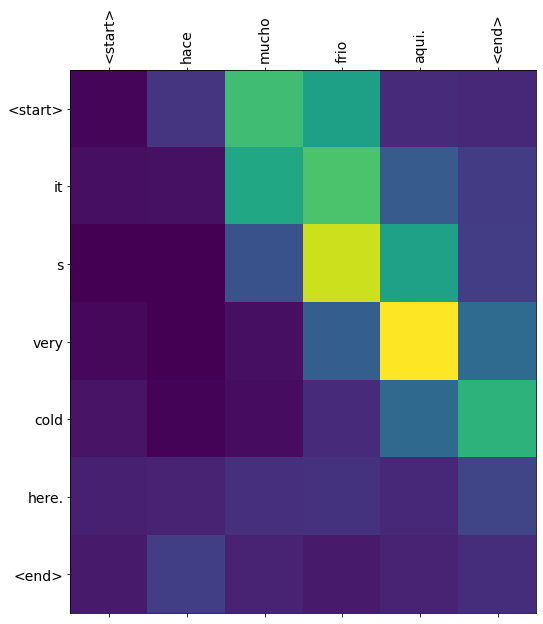

In [ ]:
s = u'hace mucho frio aqui.'
t,a = evaluate(s)
plot_attention(a[:len(t.split(' ')),:len(preprocess_sentence(s).split(' '))],preprocess_sentence(s).split(' '),t.split(' '))